# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Общая информация. 

><i>Общая информация о данных (Data overview) - это начальный этап анализа данных в Data Science, который включает в себя получение общей информации о наборе данных. Этот этап важен, чтобы понять, какие данные содержатся в наборе данных, какие проблемы могут быть связаны с этими данными, а также какие варианты анализа исследовател может применять к данным.<br><br>Общая информация о данных может включать в себя:<br>○ Размерность данных: количество строк и столбцов в наборе данных;<br>○ Типы данных: типы данных для каждого столбца в наборе данных (например, числовые, текстовые, даты);<br>○ Статистические характеристики: основные статистические метрики для каждого числового столбца, такие как среднее значение, стандартное отклонение, минимальное и максимальное значения;<br>○ Пропущенные значения: количество пропущенных значений в каждом столбце;<br>○ Уникальные значения: количество уникальных значений в каждом столбце;<br>○ Распределение данных: распределение значений в каждом столбце.<br><br>Получение общей информации о данных помогает определить, какие методы и технологии могут быть применены для анализа данных, а также какие проблемы могут возникнуть в процессе анализа. Это позволяет исследователю принимать информированные решения в процессе работы с данными.</i>

#### Импорт необходимых для исследования библиотек.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import warnings
import numpy as np
import scipy

#### Используемые кастомные функции.

In [2]:
# Custom function to add captions to barplots. Stolen from Internet
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            # add captions to the vertical barplot
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            # add captions to the horizontal barplot
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")
                
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)
        
# --------------------------------------------------------------------

# Custom function for address unification. With help of ChatGPT
def my_suggest_address(address='Нью-Васюки'):
    
    # Your API key
    # This is my personal API key
    # Please do not use it for your own purposes other than this project
    _api_key = 'f7009d57b704f36486fe2d058e61e40c11fa899c'
    # API service URL
    _url = 'https://suggestions.dadata.ru/suggestions/api/4_1/rs/suggest/address'

    # Request headers
    _headers = {
        'Content-Type': 'application/json',
        'Accept': 'application/json',
        'Authorization': f'Token {_api_key}',
    }

    # Query parameters
    if isinstance(address, str):
        _params = {
            'query': address,
            'count': 1,
        }
    else:
        return 'address is not a string'

    # Send a request and get a response
    _response = requests.post(_url, headers=_headers, json=_params)

    # Extract the address from the response
    if _response.status_code == 200:
        _suggestions = _response.json().get('suggestions')
        if _suggestions:
            _uni_address = _suggestions[0].get('value')
            if _uni_address:
                return _uni_address
            else:
                return 'unified address not found'
        else:
            return 'no suggestions found'
    else:
        return 'error occurred while retrieving data'
        
# --------------------------------------------------------------------

# Custom function for Z-score algorithm.
def my_z_score(data=pd.DataFrame(), column='', k=3):
    _low_cut = np.mean(data[column]) - k*np.std(data[column]) # mean - k*std
    _high_cut = np.mean(data[column]) + k*np.std(data[column]) # mean + k*std
    return data[(data[column] >= _low_cut) & (data[column] <= _high_cut)][column] # pd.Series in return
        
# --------------------------------------------------------------------

# Custom function for Sturges rule
'''
Yes, I know it's not exactly Sturges rule.
But the Sturges rule is a rule of thumb and empirically in this study such a logarithm is better.
So I call this function 'my_sturges'.
'''
def my_sturges(n=1000):
    return 1 + int(3.322*np.log(n))
#   return 1 + int(3.322*np.log10(n))
        
# --------------------------------------------------------------------

# Custom function for displaying the dependence of the price on various parameters
def my_prc_dep(data=pd.DataFrame(), column='', knd='bar', rt=0):
    _t = data.pivot_table(index=column , values='last_price', aggfunc='median').reset_index()
    if knd == 'scatter':
        _plot = _t.plot(kind='scatter',
                        alpha=0.7,
                        x=column,
                        y='last_price',
                        xlabel=f'{column}',
                        ylabel='Стоимость',
                        title=f'Зависимость стоимости от {column}',
                        grid=True,
                        figsize=(5,3),
                        color="DodgerBlue")
    elif knd == 'bar':
        _plot = _t.plot(kind='bar',
                        x=column,
                        y='last_price',
                        xlabel=f'{column}',
                        ylabel='Стоимость',
                        title=f'Зависимость стоимости от {column}',
                        grid=True,
                        figsize=(5,3),
                        rot=rt,
                        legend=False,
                        color="DodgerBlue") 
    else:
        print('Plot type not supported.')
        
# --------------------------------------------------------------------

# Custom function for displaying оbject parameters and histograms
def my_obj_info(df=pd.DataFrame(), cln=''):
    print('Форма гистограммы.')
    df.hist(column=cln, \
            figsize=(5, 3), \
            bins=my_sturges(len(df[cln])), \
            color = "DodgerBlue")
    plt.title(cln)
    plt.show()

    print('\nОбщие характеристики распределения.\n')
    print(df[cln].describe())

    mode, interval = scipy.stats.mode(df[cln])
    print(f'\nМода распределения: {mode[0]:.1f}')

    print(f'\nСмещение распределения: {scipy.stats.skew(df[cln]):.1f}')
        
# --------------------------------------------------------------------

# Custom function for doing some magic
def my_magic_wand(arg=''):
    if arg == 'please touch the data and plot the three parameters over the years':
        t1 = my_real_estate_data_opt.pivot_table(index='pub_yr' , values='last_price', aggfunc='median').reset_index()
        t2 = my_real_estate_data_opt.pivot_table(index='pub_yr' , values='total_area', aggfunc='median').reset_index()
        t3 = my_real_estate_data_opt.pivot_table(index='pub_yr' , values='sqr_m_prc',  aggfunc='median').reset_index()

        '''
         So as not to have to start making an omelette from the beginning of the universe, 
         all the code below is an adapted solution from the ChatGPT variants.
        '''

        # Create Figure and Axes objects
        fig, ax1 = plt.subplots()

        # Create additional axes
        ax2 = ax1.twinx()
        ax3 = ax1.twinx()

        # Shift the axes on the chart
        offset = 0.2
        ax3.spines["right"].set_position(("axes", 1.15))

        # Display each dataset on its own axis
        line1 = ax1.bar(t1.index - offset, t1['last_price'], width=0.2, color='DarkSeaGreen', label='Стоимость квартиры')
        line2 = ax2.bar(t1.index, t2['total_area'], width=0.2, color='Plum', label='Общая площадь квартиры')
        line3 = ax3.bar(t1.index + offset, t3['sqr_m_prc'], width=0.2, color='SteelBlue', label='Стоимость квадратного метра')


        # Set labels for axes
        ax1.tick_params(axis='y', labelcolor='Black')
        ax1.set_ylabel('Стоимость квартиры', color='Black')
        ax1.set_ylim(bottom=4000000)

        ax2.tick_params(axis='y', labelcolor='Black')
        ax2.set_ylabel('Общая площадь квартиры', color='Black')
        ax2.set_ylim(bottom=45)

        ax3.tick_params(axis='y', labelcolor='Black')
        ax3.set_ylabel('Стоимость квадратного метра', color='Black')
        ax3.set_ylim(bottom=85000)
        ax3.set_title('Динамика изменения параметров', fontsize=14)

        # Set up the x-axis
        ax1.set_xticks(t1.index)
        ax1.set_xticklabels(['2014', '2015', '2016', '2017', '2018', '2019'])

        # Add legends below the graph
        lines = [line1, line2, line3]
        labels = [line.get_label() for line in lines]
        ax1.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=len(lines))

        # Display the graph
        plt.show()
    else:
        print('There\'s no such a magic!')

#### Процедура получения исходных для исследования данных.
Безопасная загрузка данных из одного из возможных источников с обработкой exceptions. <br>Сепаратор `'\t'` был ранее определён предварительным просмотром данных средствами OS.

In [3]:
try:
    real_estate_data = pd.read_csv('real_estate_data.csv', \
                                   sep='\t')
    print('Данные загружены локально.')
except: # No such a file
    try:
        real_estate_data = pd.read_csv('/datasets/real_estate_data.csv', \
                                   sep='\t')
        print('Данные загружены из Практикума.')
    except: # No such a file
        try:
            real_estate_data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', \
                                           sep='\t')
            print('Данные загружены из \'yandex.net\'.')
        except: # No such a file
            print('\033[31mДанные не загружены!')

Данные загружены локально.


#### Параметры модели.

Приведенная модель исследования использует определённые допущения, регулируемые основными параметрами. Модель достаточно примитивна и нет смысла детально описывать её в начале. Вкратце, модель состоит из двух основных блоков. Первый - редукционная дискретная статистическая подготовка данных для анализа. Второй - анализ адаптированных данных и выявленных на их основе закономерностей. Настройка модели может быть осуществлена обратной связью через регулируемые параметры блоков. Их несколько:
1. Коэффициент Z-оценки допустимых выбросов данных. Метод использует средние значения и стандартные отклонения набора данных и регулируется переменной `master_k` стандартное значение которой равняется трем.
2. Параметр сборки редуцированных данных `master_inner`. Не опускаясь в детали, значение `True` соответствует минимальному количеству выбросов данных в сборке. Значение `False` соответствует наибольшей полноте данных сборки.

In [4]:
master_k = 3
master_inner = True

Параметров можно сделать и больше, но по какому количественному критерию производить оценку? Да и Jupyter notebook не сильно пригоден для этих целей.

#### Первый взгляд на загруженные данные.
> <i>...le coup de foudre...

##### Метод head().
Посмотрим на первые десять строчек DataFrame `real_estate_data`.

In [5]:
pd.set_option('display.max_columns', None) # service line for printing all columns of the table on the screen
real_estate_data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


##### Метод info().

Выведем информацию о DataFrame `real_estate_data`.

In [6]:
real_estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

##### Метод hist() для всего DataFrame.

Проведём предварительный анализ количественных данных DataFrame `real_estate_data`. Оценим разброс значений и формы статистического распределения данных.

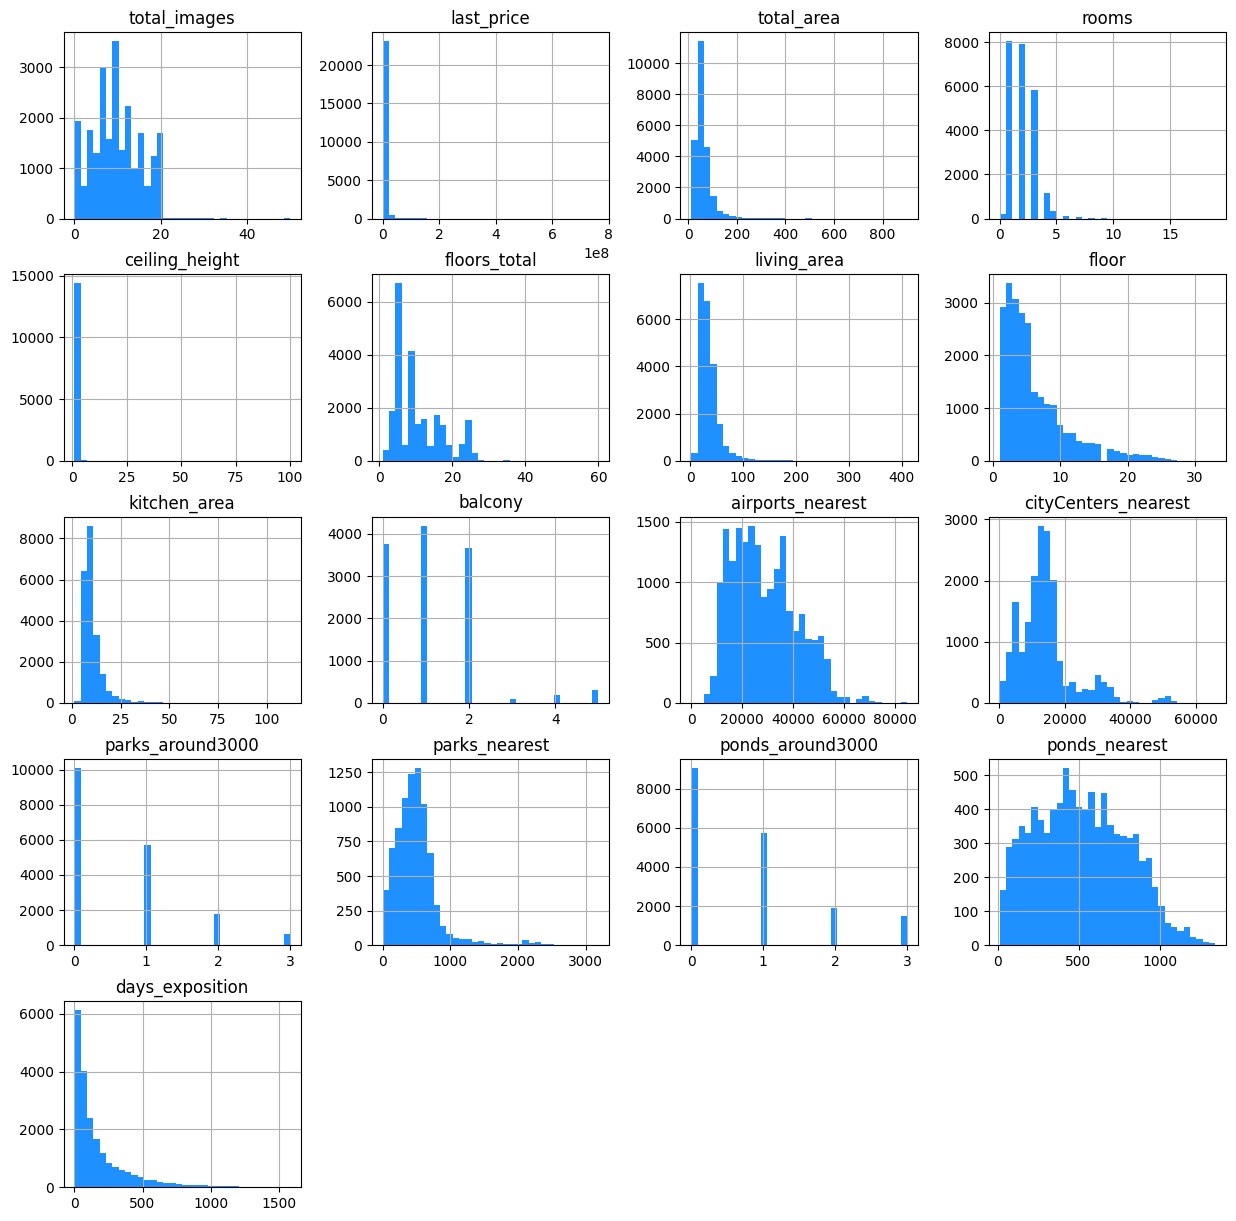

In [7]:
real_estate_data.hist(figsize=(15, 15), bins=my_sturges(real_estate_data.shape[0]), color = "DodgerBlue")
plt.show()

##### Предварительное сравнение и промежуточные выводы по данным.

Cравним полученную информацию с имеющимся описанием к данным. Сразу отметим совпадающие и не совпадающие по типу данных столбцы на котоорые нужно обратит внимание при предобработке<br><br>
<i>Описание данных</i><br>Отмеченные `[v]` столбцы в этом рассмотрении не вызывают вопросов.
- [x] `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
- [ ] `balcony` — число балконов. <font color='RoyalBlue'>float64, логичнее int64</font>
- [x] `ceiling_height` — высота потолков (м)
- [x] `cityCenters_nearest` — расстояние до центра города (м)
- [ ] `days_exposition` — сколько дней было размещено объявление (от публикации до снятия) <font color='RoyalBlue'>Лучше перевести в int64</font>
- [ ] `first_day_exposition` — дата публикации. <font color='RoyalBlue'>object, логичнее datetime64</font>
- [x] `floor` — этаж
- [ ] `floors_total` — всего этажей в доме. <font color='RoyalBlue'>float64, логичнее int64</font>
- [ ] `is_apartment` — апартаменты (булев тип). <font color='RoyalBlue'>object, должно быть bool</font> 
- [x] `kitchen_area` — площадь кухни в квадратных метрах (м²)
- [x] `last_price` — цена на момент снятия с публикации
- [x] `living_area` — жилая площадь в квадратных метрах (м²)
- [x] `locality_name` — название населённого пункта
- [x] `open_plan` — свободная планировка (булев тип)
- [ ] `parks_around3000` — число парков в радиусе 3 км. <font color='RoyalBlue'>float64, логичнее int64</font>
- [x] `parks_nearest` — расстояние до ближайшего парка (м)
- [ ] `ponds_around3000` — число водоёмов в радиусе 3 км. <font color='RoyalBlue'>float64, логичнее int64</font>
- [x] `ponds_nearest` — расстояние до ближайшего водоёма (м)
- [x] `rooms` — число комнат
- [x] `studio` — квартира-студия (булев тип)
- [x] `total_area` — общая площадь квартиры в квадратных метрах (м²)
- [x] `total_images` — число фотографий квартиры в объявлении


<i>Визуальный обзор данных.</i><br><br>
Cледует отметить, что название столбца `cityCenters_nearest` на этапе предобработки данных придётся переименовать во что-то содержащие только строчные буквы. Это же касается данных столбца `locality_name`. Кроме того, сразу обратим внимание, что DataFrame содержит пропуски. 

<i>Cтатистическая часть.</i><br><br>
Первый обзор полученных гистограмм.<br>Отмеченные `[v]` столбцы в этом рассмотрении не вызывают вопросов.
- [ ] `total_images`- <font color='RoyalBlue'>Наблюдаются выбросы относительно предполагаемого нормального распределения.</font>
- [ ] `last_price` - <font color='RoyalBlue'>Диапазон разброса желательно уменьшить.</font>
- [ ] `total_area` - <font color='RoyalBlue'>Гистограмма скошена. Но диапазон разброса желательно уменьшить.</font>
- [ ] `rooms` - <font color='RoyalBlue'>Гистограмма скошена, однако нужно смотреть, что подразумевает количество комнат $=0$.</font>
- [ ] `ceiling_height` - <font color='RoyalBlue'>Диапазон разброса желательно уменьшить.</font>
- [ ] `floors_total` - <font color='RoyalBlue'>Наблюдаются выбросы относительно предполагаемого нормального распределения.</font>
- [ ] `living_area` - <font color='RoyalBlue'>Гистограмма скошена. Но диапазон разброса желательно уменьшить.</font>
- [ ] `floor` - <font color='RoyalBlue'>Гистограмма скошена и наблюдаются провалы.</font>
- [ ] `kitchen_area` - <font color='RoyalBlue'>Гистограмма скошена. Но диапазон разброса желательно уменьшить.</font>
- [ ] `balcony` - <font color='RoyalBlue'>Нормальное распределение, но нужно смотреть данные по 4-м и более балконам.</font>
- [x] `airports_nearest` - Правдоподобно схоже с распределением Пуассона.
- [ ] `cityCenters_nearest` - <font color='RoyalBlue'>Несколько странно но, возможно, план города предполагает именно такое, волнообразное распределение.</font>
- [x] `parks_around3000` - Правдоподобно затухает.
- [x] `parks_nearest` - Гистограмма скошена.
- [x] `ponds_around3000` - Правдоподобно затухает.
- [x] `ponds_nearest` - Гистограмма скошена.
- [x] `days_exposition` - Здоровое экспоненциальное затухание.

Также практически все гистограммы имеют длинные хвосты в неадекватные области. Почти все данные требуют проверки на аномальность значений.

### Предобработка данных.

><i>Предобработка данных (Data preprocessing) - это процесс подготовки данных для анализа и обработки в целом. Она является важной частью анализа данных, поскольку качество и точность анализа зависят от качества данных.<br>Предобработка данных включает в себя ряд этапов, таких как:<br><br>○ Очистка данных: удаление поврежденных, некорректных или дублирующихся данных;<br>○ Преобразование данных: преобразование данных в нужный формат (например, перекодирование текстовых данных или приведение к числовым значениям);<br>○ Интеграция данных: объединение данных из разных источников в единый набор данных;<br>○ Выборка данных: выборка только тех данных, которые необходимы для решения конкретной задачи или анализа;<br>○ Масштабирование данных: масштабирование данных, чтобы они были в одном диапазоне значений.<br><br>
Цель предобработки данных - устранение ошибок и шума в данных, а также подготовка данных для дальнейшего анализа. Хорошо выполненная предобработка данных может повысить точность и эффективность анализа, уменьшить ошибки в моделях машинного обучения и повысить достоверность результатов.</i>

#### Оценка состояния данных.
Оценка состояния данных включает в себя проверку наличия и удаление дубликатов, обработку пропущенных значений, анализ распределения данных, поиск выбросов и аномалий, а также проверку соответствия данных форматам и ограничениям. Часть этой работы была уже предварительно выполнена в разделе выше, а здесь мы займемся исправлением ситуации. Однако сначала нужно понять, что происходит с пропусками и дубликатами.

##### Пропуски в данных.

Посмотрим на исследуемый `real_estate_data` с точки зрения распределения пропущенных значений по столбцам DataFrame.

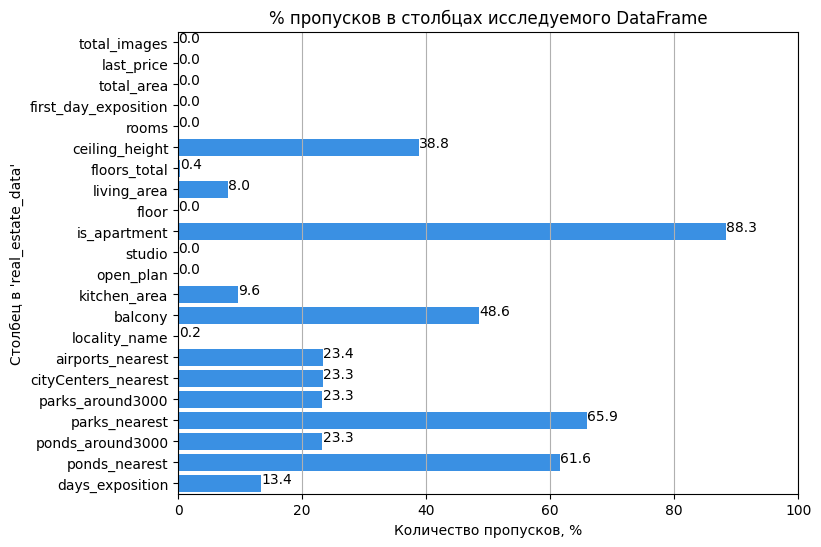

In [8]:
tmp_nan = 100 * real_estate_data.isna().sum() / real_estate_data.shape[0]

ax_tmp_nan = sns.barplot(x=tmp_nan,\
                         y=tmp_nan.index,\
                         color='DodgerBlue')

show_values(ax_tmp_nan, orient="h")

ax_tmp_nan.set(xlabel='Количество пропусков, %',\
               ylabel='Столбец в \'real_estate_data\'',\
               title='% пропусков в столбцах исследуемого DataFrame',\
               xlim=(0, 100))

ax_tmp_nan.figure.set_size_inches(8,6)
ax_tmp_nan.grid(axis='x', linestyle='-')

plt.show(ax_tmp_nan)

Выглядит обескураживающе, это не `DataFrame` - это `DataHole` какой-то, но, если приглядеться, очень многие пропуски поддаются восстановлению и данные вновь приобретают актуальность. Об этом будет ниже.

##### Дубликаты в данных.

Оценим дубликаты в столбце `locality_name`. Посмотрим на сортированный список уникальных мест расположения недвижимости.

In [9]:
pd.set_option('display.max_rows', None) # service line for printing all rows of the table on the screen

df_unique_loc = pd.DataFrame(real_estate_data['locality_name'].sort_values().unique())
df_unique_loc.columns = ['locality_name'] # For future use
df_unique_loc

,locality_name
0,Бокситогорск
1,Волосово
2,Волхов
3,Всеволожск
4,Выборг
5,Высоцк
6,Гатчина
7,Зеленогорск
8,Ивангород
9,Каменногорск


Беглый взгляд на местоположения выше сразу выявляет несколько видов дубликатов:
- дубликаты `'е'`-`'ё'`
- дубликаты `'посёлок городского типа'`-`'городской поселок'`
- возможно что-то ещё, что сразу не заметно не понизив регистр

Можно пойти предложенным в описании проекта способом: <i>Изучите уникальные значения в столбце с названиями и устраните неявные дубликаты. Например, «поселок Рябово» и «поселок городского типа Рябово», «поселок Тельмана» и «посёлок Тельмана» — это обозначения одних и тех же населённых пунктов. Вы можете заменить названия в существующем столбце или создать новый с названиями без дубликатов</i>.<br>

Тем не менее это всё таже ручная правка с небольшой долей автоматизации. И роль человеческого фактора как источника недочётов по-прежнему велика. Мы используем человеческий фактор на пользу дела и <i>пойдём другим путём</i> сохранив в том числе и жизнь букве `ё`. К тому же это будет интереснее...

#### Устранение дубликатов.

Используем полученный в разделе "Дубликаты в данных" сортированный список уникальных мест расположения недвижимости.
Само собой из этого списка `NaN` убираем вместе со всей строкой.

In [10]:
df_unique_loc.dropna(inplace=True)

Мы оставим в живых букву `ё` да и все названия населённых пунктов трогать не будем - пусть остаются с заглавными буквами. Это даже хорошо для понятности последующих отображений. Мы вообще не будем трогать столбец `'locality_name'` (sic!). Вместо этого создадим новый столбец, например, `'loc_uni'`, содержащий унифицированные названия местностей, полученные из <i>этого вашего интернета</i>. С этой целью обратимся к соответствующему сервису с соответствующими запросами. Процедура относительно времязатратная. Итак:

In [11]:
# This is very time consuming procedure for the first run
try:
    df_unique_loc = pd.read_csv('df_unique_loc.csv')
except:
    try:
        for i in range(len(df_unique_loc)):
            if 'Санкт-Петербург' not in df_unique_loc.loc[i, 'locality_name']:
                df_unique_loc.loc[i, 'loc_uni'] = my_suggest_address('Ленинградская обл, ' + df_unique_loc.loc[i, 'locality_name'])
            else:
                df_unique_loc.loc[i, 'loc_uni'] = my_suggest_address(df_unique_loc.loc[i, 'locality_name'])
        # Write the result to the file        
        try:
            df_unique_loc.to_csv('df_unique_loc.csv', index=False)
        except:
            print('\033[31mCannot write file!')
    except:
        print('\033[31mNo access to dadata!')

Ну и сразу заполним ненайденные местности их прежними значениями.

In [12]:
df_unique_loc.loc[df_unique_loc['loc_uni'] == 'no suggestions found', 'loc_uni'] = \
df_unique_loc['locality_name']

Чтобы понять, что происходит во множестве значений местностей без указанной Ленинградской области, посмотрим внутрь.

In [13]:
df_unique_loc[~df_unique_loc['loc_uni'].str.contains('Ленингр', na=False)]

,locality_name,loc_uni
15,Красное Село,Красное Село
32,Пушкин,"г Тюмень, ул Александра Пушкина"
33,Санкт-Петербург,г Санкт-Петербург
163,коттеджный поселок Кивеннапа Север,коттеджный поселок Кивеннапа Север
164,коттеджный поселок Счастье,коттеджный поселок Счастье
165,коттеджный посёлок Лесное,коттеджный посёлок Лесное
173,поселок Гарболово,поселок Гарболово
182,поселок Жилпосёлок,поселок Жилпосёлок
200,поселок Лисий Нос,поселок Лисий Нос
216,поселок Почап,поселок Почап


Но Тюмень нам тут совсем не нужна:

In [14]:
df_unique_loc.loc[df_unique_loc['loc_uni'] == 'г Тюмень, ул Александра Пушкина', 'loc_uni'] = \
df_unique_loc['locality_name']

Применим наш справочник к оригинальному `DataFrame` и сохраним результат в новый `DataFrame`. Старый нам пригодится позже для оценки проделанной работы.

In [15]:
my_real_estate_data = real_estate_data.merge(df_unique_loc, on='locality_name', how='left')

Ну и <i>вишенка на торте</i>. Для унификации переименуем столбец локации (<i>стихи</i>).

In [16]:
my_real_estate_data.rename(columns={'cityCenters_nearest': 'city_сenters_nearest'}, inplace=True)

С этой частью работы всё в порядке. Идём дальше.

#### Заполнение пропущенные значения там, где это возможно.

Вспомним имеющиеся пропуски в данных:

In [17]:
my_real_estate_data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_сenters_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
loc_uni                    49
dtype: int64

##### Столбец высоты потолка `ceiling_height`

Посмотрим уникальные значения столбца.

In [18]:
my_real_estate_data['ceiling_height'].sort_values().unique()

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

Как и было написано в описании проекта, есть значения, которые можно считать записанными в дециметрах. Это диапазон \[20; 32\], хотя минимальной нормой в России считается высота потолка 2.4 метра.<br>
Также нужно не забыть потом отбросить экзотику ниже 2 м. Есть ещё значение 100 м.  Прежде чем выкинуть его - заглянем туда:

In [19]:
my_real_estate_data.query('ceiling_height == 100')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_сenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,loc_uni
22869,0,15000000.0,25.0,2018-07-25T00:00:00,1,100.0,5.0,14.0,5,True,False,False,11.0,5.0,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0,г Санкт-Петербург


Запись выглядит логично. Оставим её, а пока просто уберем потолок, хм... Конечно, на больших массивах данных заглядывать внутрь везде - жизни не хватит и всё подобное нужно сразу резать, но тут можно и посмотреть.

In [20]:
my_real_estate_data.loc[my_real_estate_data['ceiling_height'] == 100, 'ceiling_height'] = np.nan

Займемся диапазоном \[20; 32\]

In [21]:
my_real_estate_data.loc[(my_real_estate_data['ceiling_height'] >= 20) & (my_real_estate_data['ceiling_height'] <= 32),\
                        'ceiling_height'] = my_real_estate_data['ceiling_height'] / 10

Заменим где это возможно пропущенные значения высоты потолка медианными по этажности дома.

In [22]:
warnings.simplefilter("ignore") # It is clear that there will be annoying warnings due to NaNs. Let's hide them to h@ll

for f in my_real_estate_data['floors_total'].dropna().unique():
    my_real_estate_data.loc[(my_real_estate_data['floors_total'] == f) & (my_real_estate_data['ceiling_height'].isna()), 'ceiling_height'] = \
    my_real_estate_data.loc[(my_real_estate_data['floors_total'] == f), 'ceiling_height'].median()

##### Столбец жилой площади `living_area`

Заполнение пустот здесь можно сделать следующим образом. Для каждой записи, содержащей пустую жилую площадь, заполним её медианой жилой площади по числу комнат в сегменте. Смотреть внутрь тут уже не обязательно, а экстремальные квартиры срежутся медианой. Это к тому, что тут экстремумы резать пока не будем.

In [23]:
for r in my_real_estate_data['rooms'].dropna().unique():
    my_real_estate_data.loc[(my_real_estate_data['rooms'] == r) & (my_real_estate_data['living_area'].isna()), 'living_area'] = \
    my_real_estate_data.loc[(my_real_estate_data['rooms'] == r), 'living_area'].median()

Готово.

##### Столбец "А не апартамент ли это?" `is_apartment`

Никто толком не знает, что такое "апартамент". Отмечают его, апартамента, наличие только те, кто искренне в этом уверен. Остальные пропускают и идут дальше. Следовательно, ничего страшного не случится если заполнить все пропуски нулями. В `False` это превратится позже.

In [24]:
my_real_estate_data['is_apartment'] = my_real_estate_data['is_apartment'].fillna(0)

Еще один столбец готов.

##### Столбец размера кухни `kitchen_area`

Сделаем по аналогии с жилой площадью - заполним пропуски медианными значениями по числу комнат.

In [25]:
for r in my_real_estate_data['rooms'].dropna().unique():
    my_real_estate_data.loc[(my_real_estate_data['rooms'] == r) & (my_real_estate_data['kitchen_area'].isna()), 'kitchen_area'] = \
    my_real_estate_data.loc[(my_real_estate_data['rooms'] == r), 'kitchen_area'].median()

##### Столбец количества балконов `balcony`

Тоже самое что и с апартаментами с тем отличием, что про балкон знают все, но у кого его нет считают недостойным его упоминание. Пропуски превращаем в нули.

In [26]:
my_real_estate_data['balcony'] = my_real_estate_data['balcony'].fillna(0)

##### Столбец названия населённого пункта `locality_name`

Тут пропусков не так много - 49 штук. Можно и взглянуть.

In [27]:
my_real_estate_data[my_real_estate_data['locality_name'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_сenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,loc_uni
1097,3,8600000.0,81.70,2016-04-15T00:00:00,3,3.55,5.0,50.80,2,0,False,False,8.80,0.0,NaN,23478.0,4258.0,0.0,NaN,0.0,NaN,147.0,NaN
2033,6,5398000.0,80.00,2017-05-30T00:00:00,3,3.00,4.0,42.60,2,0,False,False,18.60,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0,NaN
2603,20,3351765.0,42.70,2015-09-20T00:00:00,1,2.75,24.0,15.60,3,0,False,False,10.70,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,276.0,NaN
2632,2,5130593.0,62.40,2015-10-11T00:00:00,2,2.75,24.0,33.10,21,0,False,False,8.20,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,256.0,NaN
3574,10,4200000.0,46.50,2016-05-28T00:00:00,2,2.55,5.0,30.80,5,0,False,False,6.50,0.0,NaN,27419.0,8127.0,0.0,NaN,1.0,603.0,45.0,NaN
4151,17,17600000.0,89.50,2014-12-09T00:00:00,2,3.00,8.0,39.62,7,0,False,False,13.38,0.0,NaN,25054.0,3902.0,1.0,485.0,3.0,722.0,869.0,NaN
4189,7,9200000.0,80.00,2015-12-10T00:00:00,3,4.00,4.0,52.30,3,False,False,False,10.40,0.0,NaN,21774.0,3039.0,1.0,690.0,1.0,953.0,223.0,NaN
4670,1,5500000.0,83.00,2015-08-14T00:00:00,3,3.00,7.0,45.00,6,0,False,False,9.50,0.0,NaN,26534.0,5382.0,1.0,446.0,1.0,376.0,350.0,NaN
5343,19,13540000.0,85.50,2016-01-20T00:00:00,3,3.00,7.0,59.10,5,False,False,False,8.30,4.0,NaN,10556.0,9538.0,1.0,67.0,0.0,NaN,303.0,NaN
5707,7,3700000.0,30.00,2016-04-29T00:00:00,1,2.75,24.0,20.00,23,0,False,False,9.04,0.0,NaN,21460.0,16788.0,0.0,NaN,1.0,170.0,49.0,NaN


Эти данные мы оставим. В них что-то да есть. Причем что-то странное: местоположения нет, а расстояние от <i>того чего нет</i> до ближайшего аэропорта есть. И до центра города есть и много чего ещё есть из геолокации.

##### `days_exposition` и остальные столбцы.

Пропуски в `days_exposition` совершенно нормальны - квартиры стоят в продаже и параметр "сколько дней было размещено объявление (от публикации до снятия)" отсутствует.

Что ещё осталось в этом `DataFrame`. Это рассчетные данные геолокации:
<br>
<pre>
airports_nearest         5542
city_сenters_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
</pre>
Пропуски по столбцам "легли" изумительно и никакого другого объяснения как невозможность автоматической геолокации местоположения нет. Конечно можно что-то придумать в части расстояния до аэропорта. Но это дополнительные библиотеки геолокации и прочая канитель. Если это будет критически необходимо - можно и сделать. Пока оставим как есть.


##### Итоговая картина (маслом).

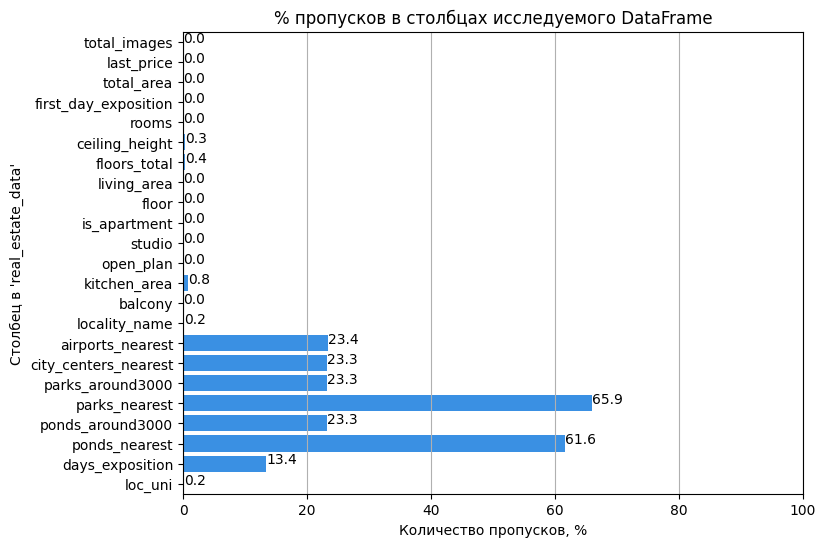

In [28]:
tmp_nan = 100 * my_real_estate_data.isna().sum() / my_real_estate_data.shape[0]

ax_tmp_nan = sns.barplot(x=tmp_nan,\
                         y=tmp_nan.index,\
                         color='DodgerBlue')

show_values(ax_tmp_nan, orient="h")

ax_tmp_nan.set(xlabel='Количество пропусков, %',\
               ylabel='Столбец в \'real_estate_data\'',\
               title='% пропусков в столбцах исследуемого DataFrame',\
               xlim=(0, 100))

ax_tmp_nan.figure.set_size_inches(8,6)
ax_tmp_nan.grid(axis='x', linestyle='-')

plt.show(ax_tmp_nan)

Стало "красивше". Посмотрим потом, что это всё нам дало.

#### Изменение типов данных.

Вспомним, что мы обнаружили в типах данных при предварительном просмотре:
- [ ] `balcony` — число балконов. <font color='RoyalBlue'>float64, логичнее int64</font>
- [ ] `days_exposition` — сколько дней было размещено объявление (от публикации до снятия) <font color='RoyalBlue'>Лучше перевести в int64</font>
- [ ] `first_day_exposition` — дата публикации. <font color='RoyalBlue'>object, логичнее datetime64</font>
- [ ] `floors_total` — всего этажей в доме. <font color='RoyalBlue'>float64, логичнее int64</font>
- [ ] `is_apartment` — апартаменты (булев тип). <font color='RoyalBlue'>object, должно быть bool</font> 
- [ ] `parks_around3000` — число парков в радиусе 3 км. <font color='RoyalBlue'>float64, логичнее int64</font>
- [ ] `ponds_around3000` — число водоёмов в радиусе 3 км. <font color='RoyalBlue'>float64, логичнее int64</font>

Если мы попробуем сделать все эти преобразования типов:
<pre>
my_real_estate_data = my_real_estate_data.astype({'balcony'          : 'int64', \
                                                  'days_exposition'  : 'int64', \
                                                  'floors_total'     : 'int64', \
                                                  'is_apartment'     : 'bool', \
                                                  'parks_around3000' : 'int64', \
                                                  'ponds_around3000' : 'int64'})
</pre>
То получим ошибку `Cannot convert non-finite values (NA or inf) to integer`. `NaN` это всегда `float64`. По крайней мере в наших версиях ПО. Ограничимся тем, что мо&#x301;жно преобразовать через `astype()`.

In [29]:
my_real_estate_data = my_real_estate_data.astype({'balcony'      : 'int', \
                                                  'is_apartment' : 'bool'})

И переведём `'first_day_exposition'` в формат `datetime64` т.к. в последующем он понадобится для аналитики. Да и вообще, так красивее.

In [30]:
my_real_estate_data['first_day_exposition'] = pd.to_datetime(my_real_estate_data['first_day_exposition'], \
                                                             format='%Y.%m.%dT%H:%M:%S')

Всё, что пока было возможно преобразовать - преобразовано.

#### Слайсинг данных и устранение редких и выбивающихся значений.

Теперь от пластической хирургии перейдем к обычной.

Нам нужно определится с четким критерием отбора данных (или удаления выбросов, как больше нравится). Возьмём метод <a href="https://ru.wikipedia.org/wiki/Z-%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B0">Z-оценок</a>. Данный метод использует среднее значение и стандартное отклонение для определения того, насколько далеко от среднего значения находится каждое измерение. Выбросы могут быть определены как значения, лежащие за пределами \$μ\pm3σ$. Сама формула для расчета Z-оценки выглядит следующим образом:
$Z=\frac{X - μ}{σ}$, где $X$ - наблюдаемое значение, $μ$ - среднее значение выборки, $σ$ - стандартное отклонение выборки.

Нужные нам данные по Series можно получить списком - `describe()` или значением - `np.mean()` и `np.std()`. Затем перейдем в стан сторонников редукционизма, разобьём `DataFrame` `my_real_estate_data` на серию обработанных Series и в завершении - соберем все обработанные серии обратно в некий новый `DataFrame`, например `my_real_estate_data_opt`.

Конечно мы утратим, например, такие интересные предложения на рынке как:

In [31]:
my_real_estate_data.query('total_area == 900')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_сenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,loc_uni
19540,8,420000000.0,900.0,2017-12-06,12,2.8,25.0,409.7,25,False,False,False,112.0,0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0,г Санкт-Петербург


Но, по правде говоря, желающие могут найти и <i>более лучший</i> вариант: <a href="https://primamedia.ru/news/1071081/">Самая большая квартира в России находится в Сочи</a>. Либо поиграться коэффициентом `k` передаваемым функции `my_z_score()`.

Гистограммы в самом начале исследования привели нас к следующим соображениям:
- [ ] `total_images`- <font color='RoyalBlue'>Наблюдаются выбросы относительно предполагаемого нормального распределения.</font>
- [ ] `last_price` - <font color='RoyalBlue'>Диапазон разброса желательно уменьшить.</font>
- [ ] `total_area` - <font color='RoyalBlue'>Гистограмма скошена. Но диапазон разброса желательно уменьшить.</font>
- [ ] `rooms` - <font color='RoyalBlue'>Гистограмма скошена, однако нужно смотреть, что подразумевает количество комнат $=0$.</font>
- [ ] `ceiling_height` - <font color='RoyalBlue'>Диапазон разброса желательно уменьшить.</font>
- [ ] `floors_total` - <font color='RoyalBlue'>Наблюдаются выбросы относительно предполагаемого нормального распределения.</font>
- [ ] `living_area` - <font color='RoyalBlue'>Гистограмма скошена. Но диапазон разброса желательно уменьшить.</font>
- [ ] `floor` - <font color='RoyalBlue'>Гистограмма скошена и наблюдаются провалы.</font>
- [ ] `kitchen_area` - <font color='RoyalBlue'>Гистограмма скошена. Но диапазон разброса желательно уменьшить.</font>
- [ ] `balcony` - <font color='RoyalBlue'>Нормальное распределение, но нужно смотреть данные по 4-м и более балконам.</font>
- [ ] `cityCenters_nearest` - <font color='RoyalBlue'>Несколько странно но, возможно, план города предполагает именно такое, <br>

Сгладим данные по этим столбцам. Прощайте интересные выбросы. No regrets.

In [32]:
# Optimized with ChatGPT
columns = ['total_images', 'last_price', 'rooms', 'ceiling_height', 'floors_total',
           'floor', 'total_area', 'living_area', 'kitchen_area', 'balcony']

z_scored = {}

for col in columns:
    z_scored[col] = my_z_score(data=my_real_estate_data, column=col, k=master_k)

total_images_z_scored   = z_scored['total_images']
last_price_z_scored     = z_scored['last_price']
rooms_z_scored          = z_scored['rooms']
ceiling_height_z_scored = z_scored['ceiling_height']
floors_total_z_scored   = z_scored['floors_total']
floor_z_scored          = z_scored['floor']
total_area_z_scored     = z_scored['total_area']
living_area_z_scored    = z_scored['living_area']
kitchen_area_z_scored   = z_scored['kitchen_area']
balcony_z_scored        = z_scored['balcony']

#### Сборка данных.

Тем не менее, ломать не строить. Каким образом собирать фрейм обратно? Понятно, что, например, методом `merge()` или `join()`, придумать то можно. Вопрос в том, как именно собирать: `left` (`right`), `outer` или `inner`. Что нам важнее: полнота данных или максимальное отсутствие выбросов? Ответить на этот вопрос пока сложно, поэтому, чтобы не писать диссертацию, сделаем выбор только для двух сборок: `inner` и `outer` и в дальнейшем посмотрим на то, как влияет этот параметр на результаты анализа. Постфактум можно будет слегка "обучить" нашу модельку. Тут же заметим, что в нашей примитивной и узкоспециальной модели анализа данных уже появляется два относительно "свободных" параметра - коэффициент Z-оценки `k` и способ сборки обработанных данных `outer` или `inner`. Вынесем их в начало исследования, в раздел "Параметры модели".<br>
P.S. Конечно тут можно каждый слайс присединять по своему. Решением будет матрица $4^9\times9$. Наверное. В любом случае, я не хочу получить диплом об окончании в дурдоме.

In [33]:
my_real_estate_data_opt = pd.DataFrame()

# Which way will we go?
if master_inner:
    my_real_estate_data_opt = pd.merge(total_images_z_scored, last_price_z_scored, left_index=True, right_index=True).\
                                 merge(rooms_z_scored, left_index=True, right_index=True).\
                                 merge(ceiling_height_z_scored, left_index=True, right_index=True).\
                                 merge(floors_total_z_scored, left_index=True, right_index=True).\
                                 merge(floor_z_scored, left_index=True, right_index=True).\
                                 merge(total_area_z_scored, left_index=True, right_index=True).\
                                 merge(living_area_z_scored, left_index=True, right_index=True).\
                                 merge(kitchen_area_z_scored, left_index=True, right_index=True).\
                                 merge(balcony_z_scored, left_index=True, right_index=True)
else:
    my_real_estate_data_opt = pd.merge(total_images_z_scored, last_price_z_scored, left_index=True, right_index=True, how='outer').\
                                 merge(rooms_z_scored, left_index=True, right_index=True, how='outer').\
                                 merge(ceiling_height_z_scored, left_index=True, right_index=True, how='outer').\
                                 merge(floors_total_z_scored, left_index=True, right_index=True, how='outer').\
                                 merge(floor_z_scored, left_index=True, right_index=True, how='outer').\
                                 merge(total_area_z_scored, left_index=True, right_index=True, how='outer').\
                                 merge(living_area_z_scored, left_index=True, right_index=True, how='outer').\
                                 merge(kitchen_area_z_scored, left_index=True, right_index=True, how='outer').\
                                 merge(balcony_z_scored, left_index=True, right_index=True, how='outer')

Присоединим остальные столбцы из исходных данных.

In [34]:
for col in my_real_estate_data.columns:
    if col not in my_real_estate_data_opt.columns:
        my_real_estate_data_opt = pd.merge(my_real_estate_data_opt, \
                                           my_real_estate_data[col], \
                                           left_index=True, \
                                           right_index=True, \
                                           how='left')

Забудем, наконец, что мы тут вообще делали и взглянем на данные заново.

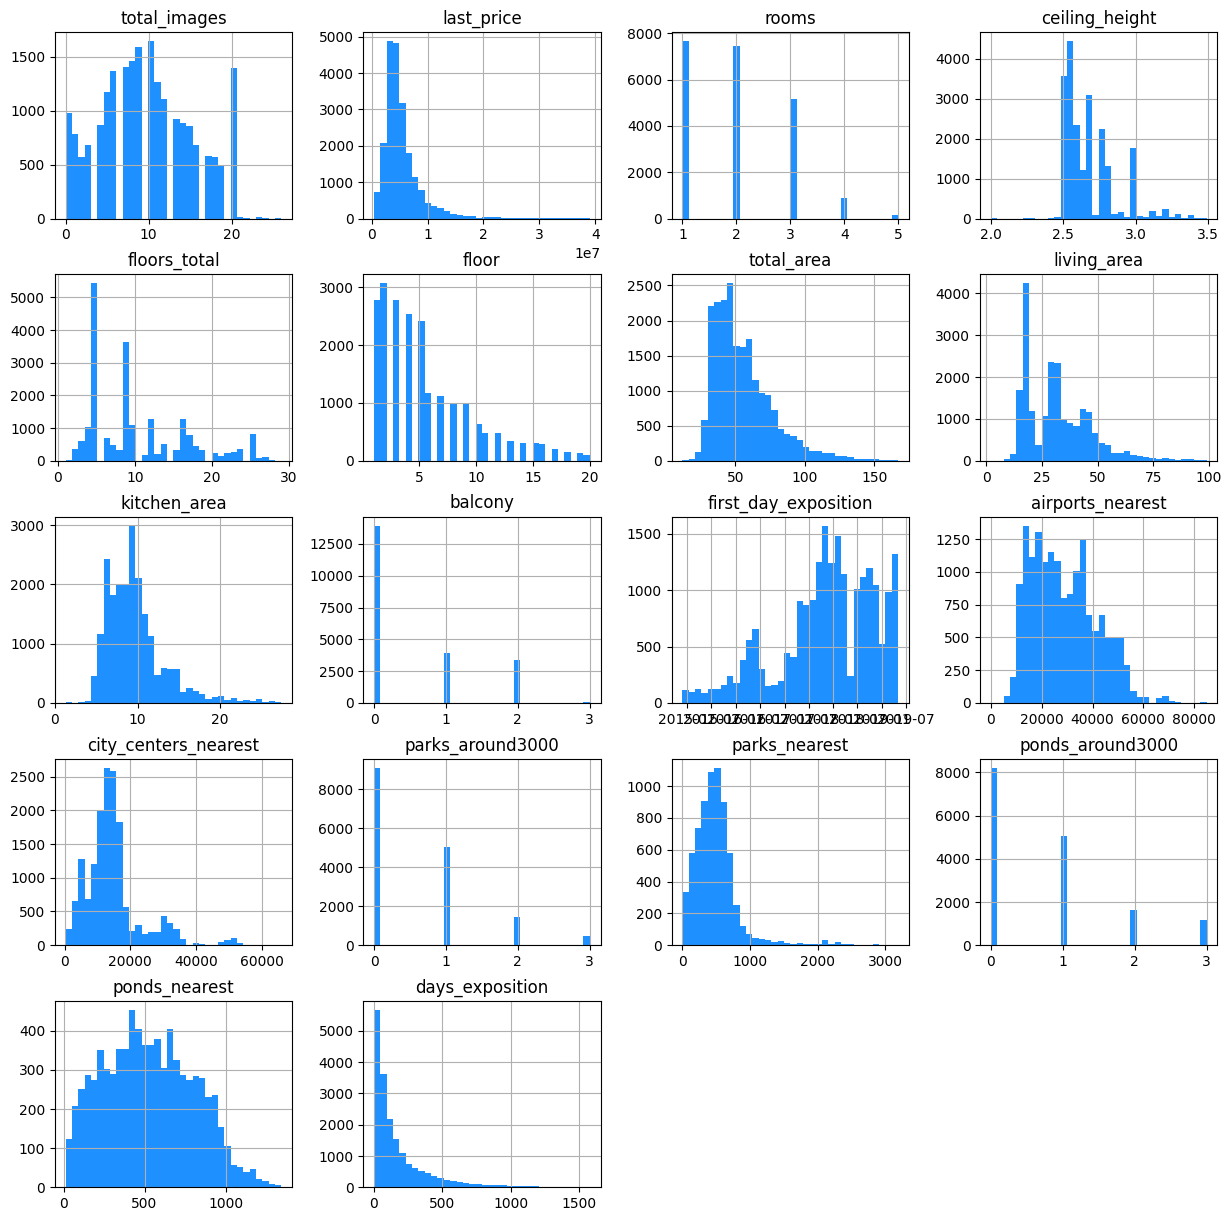

In [35]:
my_real_estate_data_opt.reset_index(drop=True, inplace=True)
my_real_estate_data_opt.hist(figsize=(15, 15), bins=my_sturges(my_real_estate_data_opt.shape[0]), color = "DodgerBlue")
plt.show()

Также выполним проверку данных на наличие явных дубликатов:

In [36]:
my_real_estate_data_opt.duplicated().sum()

0

Явные дубликаты отсутствуют.

Красиво. На этом сотворение данных для последующего более-менее адекватного анализа можно считать завершенным.

> <i>И назвал Бог сушу землёю, а собрание вод назвал морями. И увидел Бог, что \[это\] хорошо.</i>

#### Новые столбцы и категоризация.

Вы хочете новых столбцов? Их есть у меня!

In [37]:
# Цена одного квадратного метра
my_real_estate_data_opt['sqr_m_prc']   = np.round(my_real_estate_data_opt['last_price'] / my_real_estate_data_opt['total_area'], 2)

# День публикации объявления (0 - понедельник, 1 - вторник и т.д.)
my_real_estate_data_opt['pub_day']     = pd.DatetimeIndex(my_real_estate_data_opt['first_day_exposition']).dayofweek

# Месяц публикации объявления
my_real_estate_data_opt['pub_mo']      = pd.DatetimeIndex(my_real_estate_data_opt['first_day_exposition']).month

# Год публикации объявления
my_real_estate_data_opt['pub_yr']      = pd.DatetimeIndex(my_real_estate_data_opt['first_day_exposition']).year

# Расстояние в км до центра города
my_real_estate_data_opt['city_ctr_km'] = np.round(my_real_estate_data_opt['city_сenters_nearest'] / 1000)

Создать столбец типа этажа квартиры можно множеством способов. Например, используя маски:
<pre># Тип этажа квартиры (значения — «первый», «последний», «другой»)
conditions = [
    my_real_estate_data_opt['floor'] == 1,
    my_real_estate_data_opt['floor'] == my_real_estate_data_opt['floors_total'],
    (my_real_estate_data_opt['floor'] != 1) & (my_real_estate_data_opt['floor'] != my_real_estate_data_opt['floors_total'])
]

choices = [
    'первый',
    'последний',
    'другой'
]

my_real_estate_data_opt['ap_fl_type'] = np.select(conditions, choices)
</pre>
Но ниже мы сделаем это примерно в четыре (наверное) раза быстрее с использованием метода apply().

In [38]:
# Тип этажа квартиры (значения — «первый», «последний», «другой»)
my_real_estate_data_opt['ap_fl_type'] = \
my_real_estate_data_opt[['floor', 'floors_total']].apply(lambda x: \
                                                         'первый' if x[0] == 1 else \
                                                         'последний' if x[0] == x[1] else \
                                                         'другой', axis=1)

Таким образом мы создали новые столбцы, которые нам позволят в дальнейшем проводить дополнительный анализ распределения данных внутри недели, месяца, года. Введена дополнительная производная величина - стоимость одного квадратного метра. Также введена дополнительная величина категоризации - расстояние до центра города было переведено в километры и записано отдельным столбцом с округлением до целого числа, кроме этого, такая запись ещё и повышает удобство восприятия.

### Исследовательский анализ данных.

><i>Исследовательский анализ данных (Exploratory Data Analysis, EDA) - это метод исследования данных, который используется для изучения основных свойств, закономерностей и трендов в наборах данных. Цель EDA заключается в выявлении интересных аспектов данных, таких как распределение, выбросы, корреляции, зависимости и т.д., которые могут помочь в дальнейшем принятии решений на основе этих данных.</i>

#### Параметры объектов и гистограммы.

Здесь мы последовательно рассмотрим отдельные гистограммы для каждого из параметров и опишем увиденное. По эмпирическому правилу Стерджесса

Правило Стёрджеса — эмпирическое правило определения оптимального количества интервалов, на которые разбивается наблюдаемый диапазон изменения случайной величины при построении гистограммы плотности её распределения. Количество интервалов $n$ определяется как:
$n=1+[\log_2(N)]$, где $N$ - общее число наблюдений величины, $\log_2$логарифм по основанию 2, $[x]$ - обозначает целую часть числа $x$. Будем использовать запись через десятичный логарифм: $n=1+3.322\ln(N)$
<br><br>P.S. На самом деле мы сжульничаем и будем использовать натуральный логарифм т.к. он в данном исследовании очень хорошо ложится на гистограммы.<br><br>

##### Общая площадь.

Форма гистограммы.


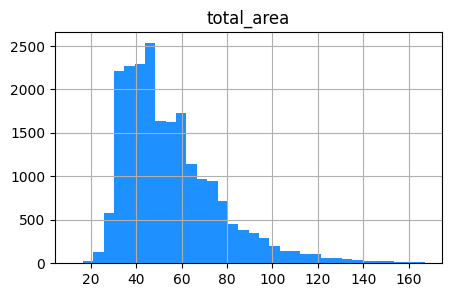


Общие характеристики распределения.

count    21312.000000
mean        55.413114
std         21.765370
min         12.000000
25%         40.000000
50%         50.100000
75%         65.892500
max        167.000000
Name: total_area, dtype: float64

Мода распределения: 45.0

Смещение распределения: 1.4


In [39]:
my_obj_info(my_real_estate_data_opt, cln='total_area')

<i>Анамнез</i>:<br>
Среднее значение смещено вправо по отношению к медианному. Гистограмма скошена.<br>
Значение асимметрии больше нуля означает, что правый хвост распределения имеет больший вес.<br>
Стандартное отклонение меньше среднего значения. Данные хорошо сгруппированы.<br>
Мода одна и наибольшее количество данных сосредоточено в области 45.<br>
Выбросы не наблюдаются.

##### Жилая площадь.


Форма гистограммы.


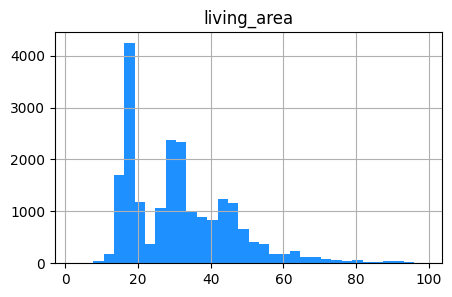


Общие характеристики распределения.

count    21312.000000
mean        31.743794
std         14.662568
min          2.000000
25%         18.100000
50%         30.000000
75%         41.000000
max         98.900000
Name: living_area, dtype: float64

Мода распределения: 18.0

Смещение распределения: 1.1


In [40]:
my_obj_info(my_real_estate_data_opt, cln='living_area')

<i>Анамнез</i>:<br>
Среднее значение смещено вправо по отношению к медианному. Гистограмма скошена.<br>
Значение асимметрии больше нуля означает, что правый хвост распределения имеет больший вес.<br>
Стандартное отклонение меньше среднего значения. Данные хорошо сгруппированы.<br>
Мода одна и наибольшее количество данных сосредоточено в области 18.<br>
Выбросы не наблюдаются. Однако есть провал чуть правее 20.<br>
Есть несколько центров группировки данных, очевидно связанных с числом комнатности квартиры.

##### Площадь кухни.


Форма гистограммы.


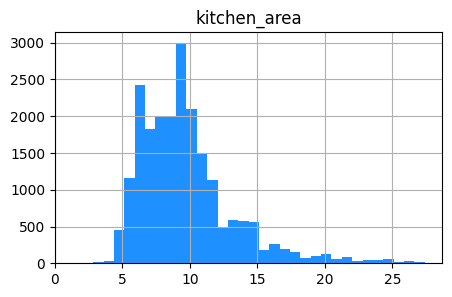


Общие характеристики распределения.

count    21312.000000
mean         9.643835
std          3.521088
min          1.300000
25%          7.000000
50%          9.000000
75%         11.000000
max         27.400000
Name: kitchen_area, dtype: float64

Мода распределения: 6.0

Смещение распределения: 1.5


In [41]:
my_obj_info(my_real_estate_data_opt, cln='kitchen_area')

<i>Анамнез</i>:<br>
Среднее значение смещено вправо по отношению к медианному. Гистограмма скошена.<br>
Значение асимметрии больше нуля означает, что правый хвост распределения имеет больший вес.<br>
Стандартное отклонение меньше среднего значения. Данные хорошо сгруппированы.<br>
Мода одна и наибольшее количество данных сосредоточено в области 6.<br>
Выбросы не наблюдаются.

##### Цена объекта.


Форма гистограммы.


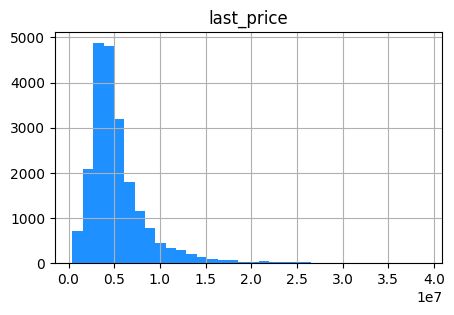


Общие характеристики распределения.

count    2.131200e+04
mean     5.385957e+06
std      3.615597e+06
min      4.300000e+05
25%      3.350000e+06
50%      4.500000e+06
75%      6.300000e+06
max      3.900000e+07
Name: last_price, dtype: float64

Мода распределения: 4500000.0

Смещение распределения: 3.0


In [42]:
my_obj_info(my_real_estate_data_opt, cln='last_price')

<i>Анамнез</i>:<br>
Среднее значение смещено вправо по отношению к медианному. Гистограмма скошена.<br>
Значение асимметрии больше нуля означает, что правый хвост распределения имеет больший вес.<br>
Стандартное отклонение меньше среднего значения. Данные хорошо сгруппированы.<br>
Мода одна и наибольшее количество данных сосредоточено в области 4,500,000.<br>
Выбросы не наблюдаются.

##### Количество комнат.


Форма гистограммы.


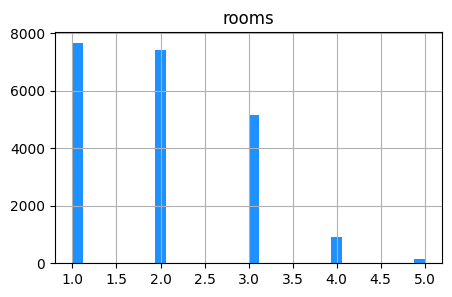


Общие характеристики распределения.

count    21312.000000
mean         1.989771
std          0.914427
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: rooms, dtype: float64

Мода распределения: 1.0

Смещение распределения: 0.6


In [43]:
my_obj_info(my_real_estate_data_opt, cln='rooms')

<i>Анамнез</i>:<br>
Среднее значение смещено влево по отношению к медианному. Гистограмма скошена.<br>
Значение асимметрии больше нуля означает, что правый хвост распределения имеет незначительно больший вес.<br>
Стандартное отклонение меньше среднего значения. Данные хорошо сгруппированы.<br>
Мода одна и наибольшее количество данных сосредоточено в области 1.<br>
Выбросы не наблюдаются.

##### Высота потолков.


Форма гистограммы.


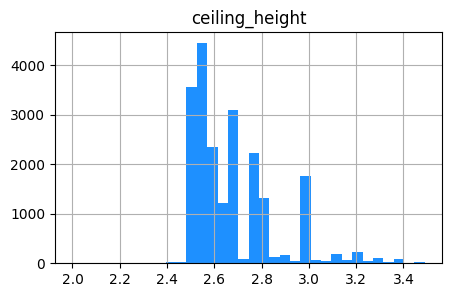


Общие характеристики распределения.

count    21312.000000
mean         2.680029
std          0.180153
min          2.000000
25%          2.550000
50%          2.650000
75%          2.750000
max          3.490000
Name: ceiling_height, dtype: float64

Мода распределения: 2.5

Смещение распределения: 1.3


In [44]:
my_obj_info(my_real_estate_data_opt, cln='ceiling_height')

<i>Анамнез</i>:<br>
Среднее значение смещено вправо по отношению к медианному. Гистограмма скошена.<br>
Значение асимметрии больше нуля означает, что правый хвост распределения имеет больший вес.<br>
Стандартное отклонение меньше среднего значения. Данные хорошо сгруппированы.<br>
Мода одна и наибольшее количество данных сосредоточено в области 2.55.<br>
Выбросы не наблюдаются.<br>
Есть несколько центров группировки данных.<br>
Данные ниже 2.4 нужно было таки отрезать.

##### Этаж квартиры.


Форма гистограммы.


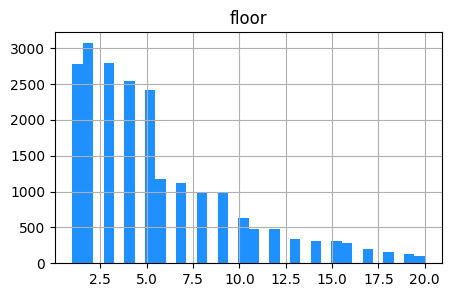


Общие характеристики распределения.

count    21312.000000
mean         5.516939
std          4.244929
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         20.000000
Name: floor, dtype: float64

Мода распределения: 2.0

Смещение распределения: 1.3


In [45]:
my_obj_info(my_real_estate_data_opt, cln='floor')

<i>Анамнез</i>:<br>
Среднее значение смещено вправо по отношению к медианному. Гистограмма скошена.<br>
Значение асимметрии больше нуля означает, что правый хвост распределения имеет больший вес.<br>
Стандартное отклонение меньше среднего значения. Данные хорошо сгруппированы.<br>
Мода одна и наибольшее количество данных сосредоточено в области 2.<br>
Выбросы не наблюдаются.

##### Тип этажа квартиры («первый», «последний», «другой»).


Форма гистограммы.

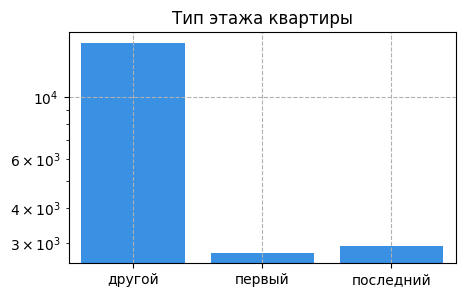

In [46]:
p_t_tmp = my_real_estate_data_opt.pivot_table(values='floor', index='ap_fl_type', aggfunc='count').reset_index()

ax_tmp = sns.barplot(x=p_t_tmp['ap_fl_type'],\
                 y=p_t_tmp['floor'],\
                 color='DodgerBlue',\
                 log=True)

ax_tmp.set(xlabel='',\
           ylabel='',\
           title='Тип этажа квартиры')

ax_tmp.figure.set_size_inches(5, 3)
ax_tmp.grid(axis='both', linestyle='--')

plt.show(ax_tmp)

<i>Анамнез</i>:<br>
\'Первых\' и \'последних\' этажей в зданиях, как ни странно, меньше (почти на порядок), чем \'других\', соответственно распределяются и предложения о продаже.

##### Общее количество этажей в доме.


Форма гистограммы.


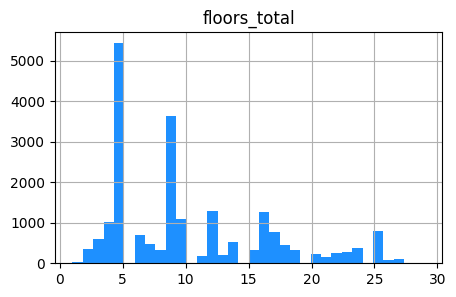


Общие характеристики распределения.

count    21312.000000
mean        10.417230
std          6.278305
min          1.000000
25%          5.000000
50%          9.000000
75%         15.000000
max         29.000000
Name: floors_total, dtype: float64

Мода распределения: 5.0

Смещение распределения: 0.9


In [47]:
my_obj_info(my_real_estate_data_opt, cln='floors_total')

<i>Анамнез</i>:<br>
Среднее значение смещено вправо по отношению к медианному. Гистограмма скошена.<br>
Значение асимметрии больше нуля означает, что правый хвост распределения имеет больший вес.<br>
Стандартное отклонение меньше среднего значения. Данные хорошо сгруппированы.<br>
Мода одна и наибольшее количество данных сосредоточено в области 5.<br>
Выбросы не наблюдаются.<br>
Есть несколько центров группировки данных, очевидно связанных с распределением этажности домов.

##### Расстояние до центра города в метрах.


Форма гистограммы.


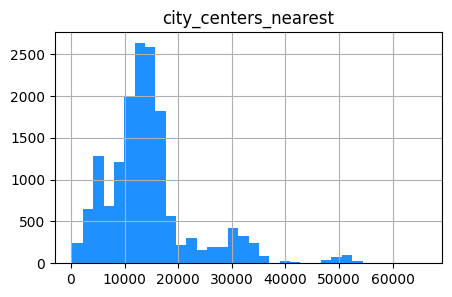


Общие характеристики распределения.

count    16109.000000
mean     14582.898690
std       8606.025423
min        287.000000
25%       9877.000000
50%      13275.000000
75%      16425.000000
max      65968.000000
Name: city_сenters_nearest, dtype: float64

Мода распределения: 8460.0

Смещение распределения: nan


In [48]:
my_obj_info(my_real_estate_data_opt, cln='city_сenters_nearest')

<i>Анамнез</i>:<br>
Среднее значение смещено вправо по отношению к медианному. Гистограмма скошена.<br>
Значение асимметрии по причине большого количества пропусков не может быть рассчитано.<br>
Стандартное отклонение меньше среднего значения. Данные хорошо сгруппированы.<br>
Мода одна и наибольшее количество данных сосредоточено в области 8460.<br>
Выбросы не наблюдаются.<br>
Волнообразная форма распределения возможно отражает структуру концентрации населения Лен области по радиусу удаления от центра СПБ.

##### Расстояние до ближайшего аэропорта.


Форма гистограммы.


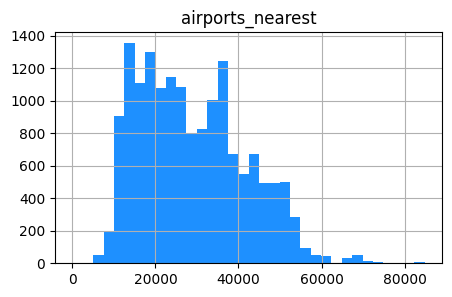


Общие характеристики распределения.

count    16089.000000
mean     28846.097458
std      12755.105912
min          0.000000
25%      18278.000000
50%      27016.000000
75%      37412.000000
max      84869.000000
Name: airports_nearest, dtype: float64

Мода распределения: 37434.0

Смещение распределения: nan


In [49]:
my_obj_info(my_real_estate_data_opt, cln='airports_nearest')

<i>Анамнез</i>:<br>
Среднее значение смещено вправо по отношению к медианному. Гистограмма скошена.<br>
Значение асимметрии по причине большого количества пропусков не может быть рассчитано.<br>
Стандартное отклонение меньше среднего значения. Данные хорошо сгруппированы.<br>
Мода одна и наибольшее количество данных сосредоточено в области 37434.<br>
Выбросы не наблюдаются.

##### Расстояние до ближайшего парка.


Форма гистограммы.


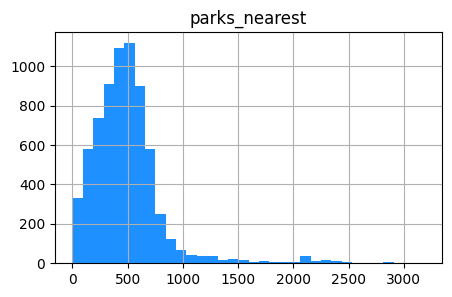


Общие характеристики распределения.

count    6993.000000
mean      493.742600
std       342.388318
min         1.000000
25%       290.000000
50%       456.000000
75%       613.000000
max      3190.000000
Name: parks_nearest, dtype: float64

Мода распределения: 441.0

Смещение распределения: nan


In [50]:
my_obj_info(my_real_estate_data_opt, cln='parks_nearest')

<i>Анамнез</i>:<br>
Среднее значение смещено вправо по отношению к медианному. Гистограмма скошена.<br>
Значение асимметрии по причине большого количества пропусков не может быть рассчитано.<br>
Стандартное отклонение меньше среднего значения. Данные хорошо сгруппированы.<br>
Мода одна и наибольшее количество данных сосредоточено в области 441.<br>
Выбросы не наблюдаются.

##### День и месяц публикации объявления.


Форма гистограммы.


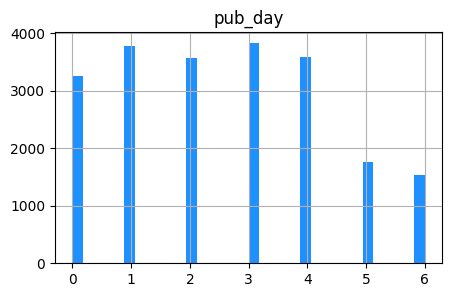


Общие характеристики распределения.

count    21312.000000
mean         2.570242
std          1.792623
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: pub_day, dtype: float64

Мода распределения: 3.0

Смещение распределения: 0.2


In [51]:
my_obj_info(my_real_estate_data_opt, cln='pub_day')

<i>Анамнез</i>:<br>
Среднее значение смещено влево по отношению к медианному. Гистограмма скошена.<br>
Значение асимметрии больше нуля означает, что правый хвост распределения имеет незначительно больший вес.<br>
Стандартное отклонение меньше среднего значения. Данные хорошо сгруппированы.<br>
Мода одна и наибольшее количество данных сосредоточено в области 3.<br>
Выбросы не наблюдаются.<br>
В воскресенье люди больше предпочитают отдыхать и не заниматься делами.

Форма гистограммы.


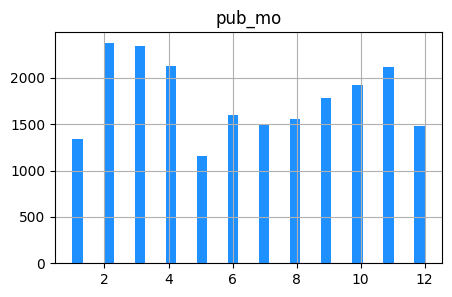


Общие характеристики распределения.

count    21312.000000
mean         6.395927
std          3.490908
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: pub_mo, dtype: float64

Мода распределения: 2.0

Смещение распределения: 0.1


In [52]:
my_obj_info(my_real_estate_data_opt, cln='pub_mo')

<i>Анамнез</i>:<br>
Среднее значение практически не смещено по отношению к медианному. Гистограмма не скошена.<br>
Значение асимметрии практически около нуля, что правый хвосты распределения имеет почти одинаковый вес.<br>
Стандартное отклонение меньше среднего значения. Данные хорошо сгруппированы.<br>
Мода одна и наибольшее количество данных сосредоточено в области 2.<br>
Выбросы не наблюдаются.<br>
Подъём числа размещаемых объявлений приходится на весенне-осенний период. Что вообще-то не особо удивительно. Тем не менее сезонность налицо.

#### Оценка скорости продажи квартиры.

Форма гистограммы.


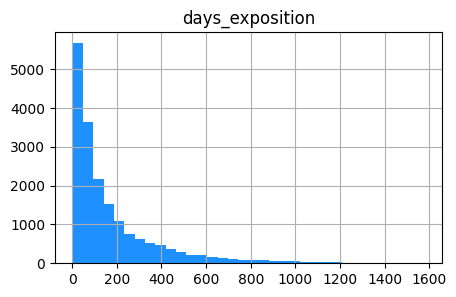


Общие характеристики распределения.

count    18588.000000
mean       177.131590
std        215.559858
min          1.000000
25%         44.000000
50%         93.000000
75%        226.000000
max       1580.000000
Name: days_exposition, dtype: float64

Мода распределения: 45.0

Смещение распределения: nan


In [53]:
my_obj_info(my_real_estate_data_opt, cln='days_exposition')

<i>Анамнез</i>:<br>
Среднее значение существенно смещено вправо по отношению к медианному. Гистограмма скошена.<br>
Значение асимметрии по причине большого количества пропусков не может быть рассчитано.<br>
Стандартное отклонение значительно больше среднего значения. Данные не сгруппированы.<br>
Мода одна и наибольшее количество данных сосредоточено в области 45.<br>
Выбросы не наблюдаются.<br>

Делаем data close-up в дапазон \[0-100\].

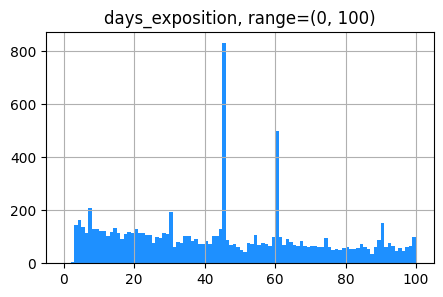

In [54]:
my_real_estate_data_opt.hist(column='days_exposition', \
                             figsize=(5, 3), \
                             bins=100, \
                             color="DodgerBlue", \
                             range=(0, 100))
plt.title('days_exposition, range=(0, 100)')
plt.show()


Гистограмма диапазона \[0, 100\] показывает значительное увеличение продаж на последовательности дней (15, 30, 45, 60, 75, 90). Статистически это означает, что это не продажи itself, а что-то другое. Поскольку я, конечно, много кем за свою жизнь поработал, но вот в этой области нет, то и соображений у меня увы нет, кроме того, что объявления в эти дни активно закрываются, а поскольку это происходит с периодичностью 15 дней, то тут или крон какой-то чистит базу или...

Таким образом можно утверждать, что:<br>
○ Продажа квартиры в большинстве случаев занимает около 45 дней.<br>
○ Наиболее быстрыми продажами можно считать продажи совершенные за менее чем 44 дня (первый квартиль отсечения).<br>
○ Наиболее необычно долгими продажами можно считать продажи совершенные за более чем 226 дней (третий квартиль отсечения).

#### Факторы больше всего влияющие на общую (полную) стоимость объекта.

Посмотрим, зависит ли цена от:
- общей площади;
- жилой площади;
- площади кухни;
- количества комнат;
- этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год).

##### Корреляция данных.

Прежде, чем рисовать графики посмотрим зависимости известным методом corr().

In [55]:
tmp_cor = my_real_estate_data_opt.corr()['last_price'].sort_values(ascending=False)

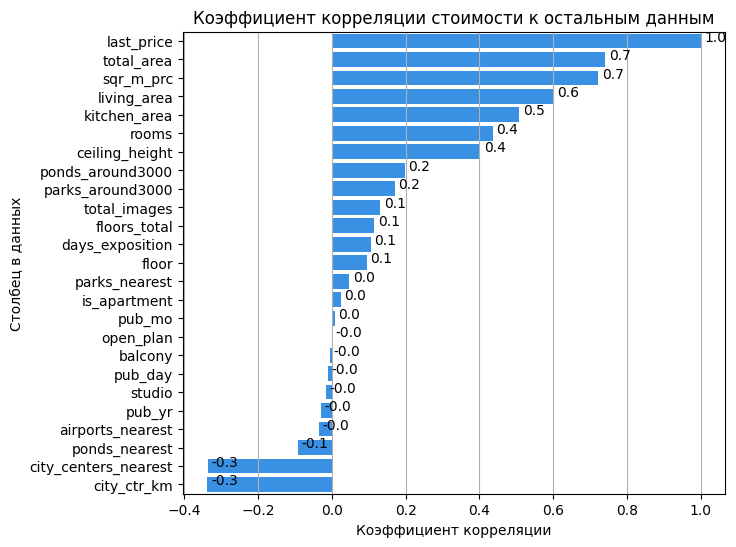

In [56]:
ax_tmp_cor = sns.barplot(x=tmp_cor,\
                         y=tmp_cor.index,\
                         color='DodgerBlue')

show_values(ax_tmp_cor, orient="h")

ax_tmp_cor.set(xlabel='Коэффициент корреляции',\
               ylabel='Столбец в данных',\
               title='Коэффициент корреляции стоимости к остальным данным')

ax_tmp_cor.figure.set_size_inches(7,6)
ax_tmp_cor.grid(axis='x', linestyle='-')

plt.show(ax_tmp_cor)

Мы сразу видим ожидаемые положительные корреляции между стоимостью квартиры и: общей площадью, жилой площадью, площадью кухни, количеством комнат и высотой потолка. Отметим, что корреляция между стоимостью квартиры и стоимостью квадратного метра жилья не равна единице. Теперь можно и посмотреть графики.

##### Общая площадь.

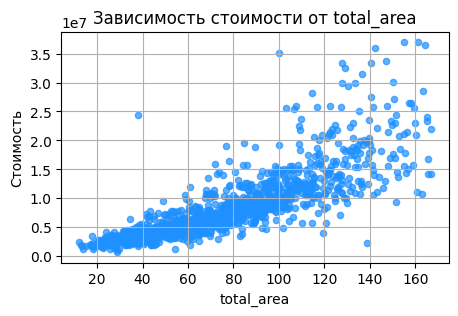

In [57]:
my_prc_dep(data=my_real_estate_data_opt, column='total_area', knd='scatter')

Наличие предполагаемой положительной корреляции.

##### Жилая площадь.

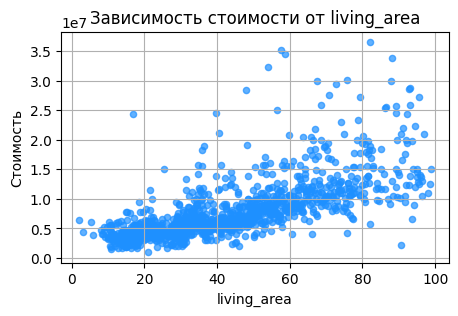

In [58]:
my_prc_dep(data=my_real_estate_data_opt, column='living_area', knd='scatter')

Наличие предполагаемой положительной корреляции.

##### Площадь кухни.

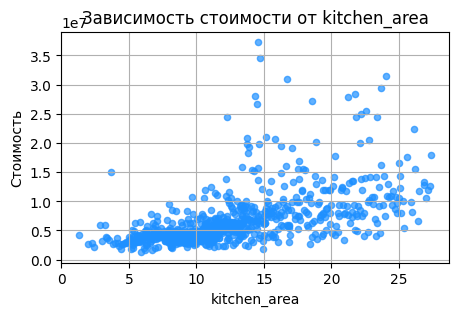

In [59]:
my_prc_dep(data=my_real_estate_data_opt, column='kitchen_area', knd='scatter')

При желании можно убидеть слабую положительную корреляцию.

##### Количество комнат.

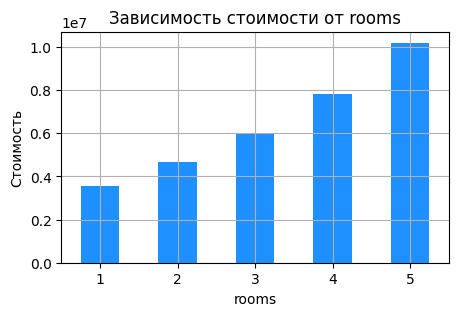

In [60]:
my_prc_dep(data=my_real_estate_data_opt, column='rooms', knd='bar')

##### Этаж.

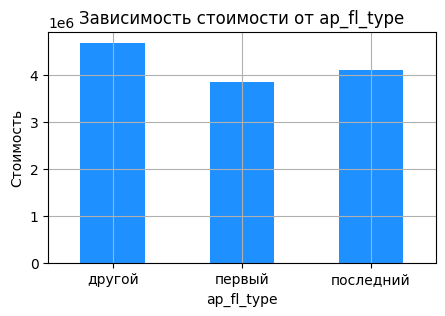

In [61]:
my_prc_dep(data=my_real_estate_data_opt, column='ap_fl_type', knd='bar')

Первые и последние этажи. Несколько дешевле. При этом помним, что в категории "другой" находятся нулевые этажи.

##### Дата размещения.

###### Год.

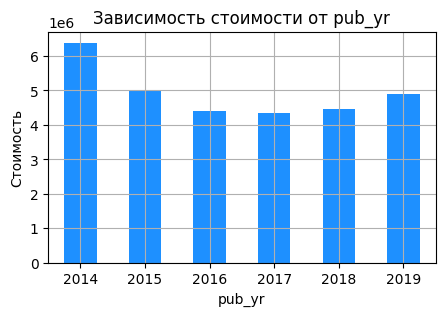

In [62]:
my_prc_dep(data=my_real_estate_data_opt, column='pub_yr', knd='bar')

В наблюдаемом диапазане можно утверждать, что в 2014 году и далее на рынке происходил спад, который достиг своего минимума к 2017 году, начиная с которого рынок начал отыгрывать предыдущее снижение цен. Возможно мы наблюдаем U образную коррекцию рынка.

Для того, чтобы подтвердить или опровергнуть предположение об U-образной коррекции на рынке рассмотрим динамику изменения дополнительных к стоимости квартиры параметров, таких как общая площадь квартиры и стоимость квадратного метра.

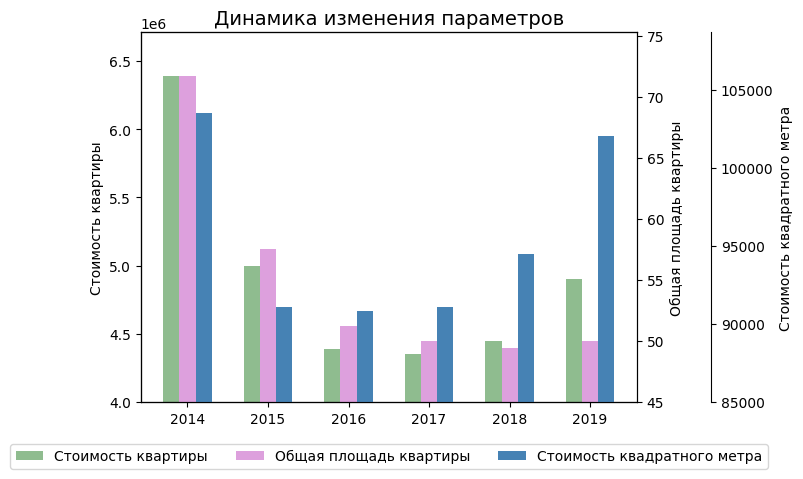

In [63]:
my_magic_wand('please touch the data and plot the three parameters over the years')

Действительно, укрупненный масштаб движения стоимости квартир носит U-образный характер, однако L-образная коррекция общей площади квартир за тот-же промежуток времени говорит о несколько другом характере снижения цен. Вместо того, чтобы говорить об общем снижении стоимости квартир на рынке уместнее связать это снижение не с падением цен как таковых, а с уменьшением общей площади экспонируемых квартир. Это может быть связано в том числе и с уменьшением объема предложения в части многокомнатных квартир относительно большой площади. Тем не менее, данная динамика вполне отыгрывается другим важным индикатором - стоимостью квадратного метра жилья, который показывает устойчивый тренд к росту начиная с 2017 года.

###### Месяц.

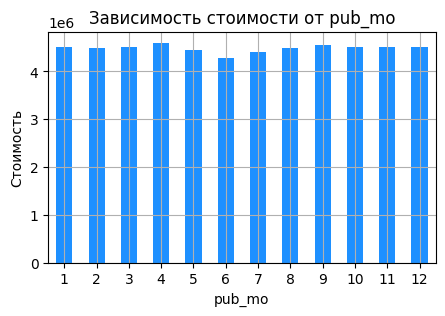

In [64]:
my_prc_dep(data=my_real_estate_data_opt, column='pub_mo', knd='bar')

Зависимости цены от месяца публикации практически не наблюдается.

###### День недели.

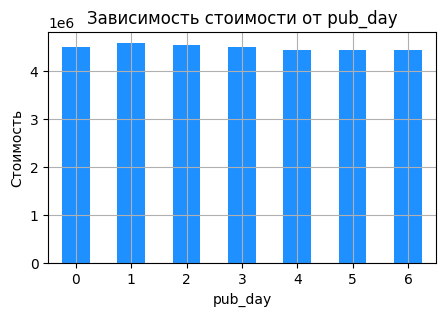

In [65]:
my_prc_dep(data=my_real_estate_data_opt, column='pub_day', knd='bar')

Зависимости цены от дня публикации практически не наблюдается.

#### Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Населённые пункты с самой высокой и низкой стоимостью квадратного метра.

##### Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [66]:
sqr_m_prc_by_loc = my_real_estate_data_opt.pivot_table(index='loc_uni', values='sqr_m_prc', aggfunc=['median', 'count']).\
                                 reset_index().\
                                 sort_values(by=('count', 'sqr_m_prc'), ascending=False)
sqr_m_prc_by_loc.columns=['locality','average_cost_per_square_meter','number_of_placed ads']
sqr_m_prc_by_loc.head(10)

,locality,average_cost_per_square_meter,number_of_placed ads
291,г Санкт-Петербург,103201.970,13855
33,"Ленинградская обл, Всеволожский р-н, г Мурино",84726.220,501
32,"Ленинградская обл, Всеволожский р-н, г Кудрово",95918.920,415
311,посёлок Шушары,77272.730,401
275,"Ленинградская обл, г Всеволожск",65540.540,373
290,Пушкин,99596.340,340
266,"Ленинградская обл, Тосненский р-н, дорога Подъ...",74657.530,327
279,"Ленинградская обл, г Гатчина",67746.285,292
305,посёлок Парголово,90859.360,264
276,"Ленинградская обл, г Выборг",57894.740,223


##### Населённые пункты с самой высокой и низкой стоимостью квадратного метра.

In [67]:
sqr_m_prc_by_loc = sqr_m_prc_by_loc.sort_values(by=('average_cost_per_square_meter'), ascending=False)

Самая высокая стоимость квадратного метра.

In [68]:
sqr_m_prc_by_loc.query('average_cost_per_square_meter == average_cost_per_square_meter.max()')

,locality,average_cost_per_square_meter,number_of_placed ads
303,посёлок Лисий Нос,121616.225,2


Самая низкая стоимость квадратного метра.

In [69]:
sqr_m_prc_by_loc.query('average_cost_per_square_meter == average_cost_per_square_meter.min()')

,locality,average_cost_per_square_meter,number_of_placed ads
248,"Ленинградская обл, Сланцевский р-н, деревня Ст...",11000.0,3


#### Выделяем квартиры в Санкт-Петербурге и вычисляем среднюю цену каждого километра и описываем, как стоимость объектов зависит от расстояния до центра города.

In [70]:
spb_loc = my_real_estate_data_opt.query('loc_uni == "г Санкт-Петербург"')

In [71]:
spb_loc_prc_by_dist = spb_loc.pivot_table(index='city_ctr_km', values='last_price').\
                                          reset_index().\
                                          sort_values(by='city_ctr_km', ascending=False)

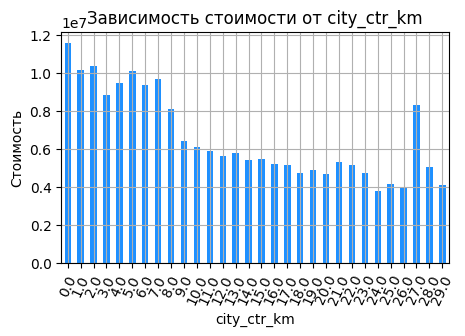

In [72]:
my_prc_dep(data=spb_loc_prc_by_dist, column='city_ctr_km', knd='bar', rt=65)

Видно уменьшение стоимости жилья по мере удаления от центра (кстати это далеко не характерно для многих других городов мира). Однако на этом спаде сильно выделяется 27-й километр. Изучение этого всплеска можно оставить на потом. 

### Общий вывод

>"Общий вывод" в DataScience - это заключение, которое делается на основе анализа данных и представляет собой краткое описание результатов и выводов, полученных в ходе анализа. Общий вывод обычно включает в себя ответы на исходные вопросы и цели проекта, а также описание значимых результатов и выводов, которые могут быть полезны для решения бизнес-проблемы или научной задачи.

<b>Цель исследования.</b><br><br>
Итак, имеются исходные данные сервиса Яндекс Недвижимость — архив объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах.<br>
Задача — выполнить предобработку данных и изучить их, чтобы найти интересные особенности и зависимости, которые существуют на рынке недвижимости.<br>
О каждой квартире в базе содержится два типа данных: добавленные пользователем и картографические. Например, к первому типу относятся площадь квартиры, её этаж и количество балконов, ко второму — расстояния до центра города, аэропорта и ближайшего парка. 
<br><br>

<b>Исходные данные.</b><br><br>
Таблица в формате Comma-Separated Values содержащая следующие позиции:
<pre>airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
balcony — число балконов
ceiling_height — высота потолков (м)
cityCenters_nearest — расстояние до центра города (м)
days_exposition — сколько дней было размещено объявление (от публикации до снятия)
first_day_exposition — дата публикации
floor — этаж
floors_total — всего этажей в доме
is_apartment — апартаменты (булев тип)
kitchen_area — площадь кухни в квадратных метрах (м²)
last_price — цена на момент снятия с публикации
living_area — жилая площадь в квадратных метрах (м²)
locality_name — название населённого пункта
open_plan — свободная планировка (булев тип)
parks_around3000 — число парков в радиусе 3 км
parks_nearest — расстояние до ближайшего парка (м)
ponds_around3000 — число водоёмов в радиусе 3 км
ponds_nearest — расстояние до ближайшего водоёма (м)
rooms — число комнат
studio — квартира-студия (булев тип)
total_area — общая площадь квартиры в квадратных метрах (м²)
total_images — число фотографий квартиры в объявлении
</pre>
При первичном Data overview выявлены следующие особенности предоставленных данных:<br>
- Сравнение описания данных с выведенной информацией по реально предоставленными показывает расхождение существующих и ожидаемых типов данных по значительному количеству стобцов.<br>
- Визуальный просмотр среза первых строк данных свидетельствует о наличии пропусков и желательной небольшой корректировке в названии одного из столбцов, что также подтверждается анализом DataFrame.<br>
- Статистический анализ данных показывает наличие длинных хвостов распределения во многих столбцах, а также существование аномально больших и аномально малых значений.
<br><br>

<b>Предобработка данных.</b><br><br>
Проведенный Data preprocessing позволил преобразовать данные к удобному для анализа виду путём произведения нижеследующих операций.<br>

<i><b>Заполнение пропусков в данных.</b></i><br>
<i><u>Высота потолков</u>.</i> В разумном диапазоне высота потолков была переведена из дециметров в метры. Пропущенные значения были заполнены медианными по этажности дома.<br>
<i><u>Жилая площадь</u>.</i> Пропуски заполнены медианой жилой площади по числу комнат в сегменте.<br>
<i><u>Апартаменты</u>.</i> Пропуски были заполнены нулевым значением означающим не соответствие категории "апартамент".<br>
<i><u>Площадь кухни</u>.</i> Пропуски заполнены медианными значениями по числу комнат.<br>
<i><u>Число балконов</u>.</i> Пропуски заполнены нулевыми значениями в предположении, что отсутствие информации говорит в большинстве случаев об отсутствии балкона.<br>
<i><u>Название населённого пункта</u>.</i> Пропуски оставлены по причине наличия в соответствующих строках информативных данных.<br>
<i><u>Сколько дней было размещено объявление</u>.</i> Пропуски совершенно закономерны по причине того, что квартира может находится в продаже на момент снятия данных.<br><br>
Пропуски в столбцах содержащих автоматические данные геолокации оставлены без изменений.<br>

<i><b>Устранение дубликатов в данных.</b></i><br>
Анализ уникальных значений столбца с названием населённого пункта показал наличие неявных дубликатов. Для более надежного, чем ручное, устранения дубликатов была произведена автоматическая проверка, исправление и геокодирование адресов с использованием внешнего сервиса. Данные недублированных значений записаны в отдельный столбец.<br>

<i><b>Изменение типов данных.</b></i><br>
Столбец содержащий даты публикации преобразован к типу `datetime64`. Столбцы не содержащие значений `NaN` также были преобразованы к своим типам. Столбцы содержащие `NaN` по причине ограничений в программном обеспечении были оставлены как есть.<br>

<i><b>Устранение редких и выбивающихся значений.</b></i><br>
На основе проведенного ранее статистического анализа данных был составлен список столбцов с аномальными значениями. Данные столбцы были выделены из общего набора и далее обрабатывались как независимые серии. К каждой серии был применён метод отбора на основании Z-оценок. Далее была осуществлена обратная 'inner' сборка. Возможен вариант сборки 'outer', но конкретный способ зависит от того что в данном анализе важнее: полнота данных или максимальное отсутствие выбросов. Поставленная задача предполагает нахождение зависимостей, в этой связи сборка осуществлена именно так.<br>
Выполненный по завершении этой процедуры статистический анализ для всего объема данных, в сравнении с проведённым для оригинальных данных, показал достаточную её (процедуры) эффективность.<br>

<i><b>Новые столбцы и категоризация.</b></i><br>
В завершение предобработки данных были созданы новые столбцы содержащие данные о:
- Цена одного квадратного метра.
- День недели публикации объявления.
- Месяц публикации объявления.
- Год публикации объявления.
- Расстояние в км до центра города.
- Тип этажа квартиры (категоризация по типам "первый", "последний», "другой").
<br><br>

<b>Исследовательский анализ данных.</b><br><br>
Проведенный Exploratory Data Analysis позволил выявить следующие закономерности в предоставленных данных.<br>

<i><b>Параметры объектов и гистограммы.</b></i><br>
<i><u>Общая площадь</u>. </i>На хорошо сгруппированных данных виден весомый хвост в сторону больших площадей, тем не менее большинство из данных сосредоточено вокруг значения 45м$^2$. Это наиболее представленная рынке площадь жилья выставленного на продажу.<br>
<i><u>Жилая площадь</u>. </i>Данные сгруппированы и сегментированы. Сегментация скорее всего связана с распределение жилой площади по комнатности квартир. Тем не менее нельзя исключать влияние способа заполнения пропусков. Мода в области 18м$^2$ возможно указывает на продажу комнат в "коммуналках" в то время как второй максимум в области 30м$^2$ скорее всего говорит о популярности к продаже однокомнатных квартир.<br>
<i><u>Площадь кухни</u>. </i>Данные также сгруппированы в области 6м$^2$ и немного меньше в области 9м$^2$. Это довольно распространённые площади кухонь на территории бывшего советского союза.<br>
<i><u>Цена объекта</u>. </i>Данные хорошо сгруппированы с модой распределения в области 4,500,000, что указывает на наиболее распространённый ценовой запрос на данном рынке.<br>
<i><u>Количество комнат</u>. </i>Данные хорошо сгруппированы с модой распределения равной 1. Однокомнатные квартиры являются наиболее экспонированными на рынке продаж.<br>
<i><u>Высота потолков</u>. </i>Данные сгруппированы с модой распределения равной 2.5м. Далее идут более высокопотолочные квартиры (например 3м), которые представлены в несколько меньшем количестве.<br>
<i><u>Этаж квартиры</u>. </i>Данные хорошо сгруппированы с модой распределения равной 2. Вероятно это самый экспонированный на рынке этаж.<br>
<i><u>Тип этажа квартиры</u>. </i>Первые и последние этажи зданий представлены на рынке примерно в своём распределении к остальным этажам - почти на порядок меньше.<br>
<i><u>Общее количество этажей в доме</u>. </i>Данные хорошо сгруппированы с модой распределения равной 5 и дальнейшими убывающими центрами группировок в районах 9, 12, 16, 25. Здания 5-ти этажей самые массовые на рынке продаж.<br>
<i><u>Расстояние до центра города в метрах.</u> </i>Данные хорошо сгруппированы с модой распределения равной примерно 8.5км с дальнейшим волнообразным затуханием, но чрезмерным числом пропусков, что говорит о имеющихся данных только для крупных образований. Большинство продаж находится в области 8.5км от центра города.<br>
<i><u>Расстояние до ближайшего аэропорта</u>. </i>Данные хорошо сгруппированы с модой распределения равной примерно 37км с дальнейшим волнообразным затуханием, но чрезмерным числом пропусков, что говорит о имеющихся данных только для крупных образований. Тем не менее существенное количество продаж сосредоточено в области примерно 15-20км. Однако всё-таки большинство квартир на продажу находятся на удалении около 37км от ближайшего аэропорта.<br>
<i><u>Расстояние до ближайшего парка</u>. </i>Данные хорошо сгруппированы с модой распределения равной примерно 441м, но чрезмерным числом пропусков, что говорит о имеющихся данных только для крупных образований. Таким образом самый распространённый вариант находится в примерно 440 метров от парка<br>
<i><u>День публикации объявления</u>. </i>Данные показывают, что наименьшая активность размещения объявлений приходится на субботу и воскресенье. Начиная с понедельника активность существенно возрастает.<br>
<i><u>Месяц публикации объявления</u>. </i>Данные показывают, что весенне-осенний период выделяется существенным увеличением размещаемых объявлений о продаже. Выделяется строгая сезонность в распределении. Минимум размещений приходится на май месяц.<br>
<i><u>Оценка скорости продажи квартиры</u>. </i>Можно утверждать, что:
○ Продажа квартиры в большинстве случаев занимает около 45 дней.
○ Наиболее быстрыми продажами можно считать продажи совершенные за менее чем 44 дня.
○ Наиболее необычно долгими продажами можно считать продажи совершенные за более чем 226 дней.<br>

<i><b>Факторы больше всего влияющие на общую (полную) стоимость объекта.</b></i><br>
<i><u>Общая площадь.</u>.</i> Имеется предполагаемая положительная коррекция со стоимостью квартиры.<br>
<i><u>Площадь кухни.</u>.</i> Положительная коррекция отсутствует или не очевидна.<br>
<i><u>Количество комнат.</u>.</i> Положительная коррекция очевидна и видимо связана напрямую о общей площадью.<br>
<i><u>Этаж.</u>.</i> Первые и последние этажи проигрывают до 10-20% стоимости.<br>
<i><u>Дата размещения..</u>.</i> В наблюдаемом диапазоне можно утверждать, что в 2014 году и далее на рынке происходил спад, который достиг своего минимума к 2017 году, начиная с которого рынок начал отыгрывать предыдущее снижение цен. Возможно мы наблюдаем U образную коррекцию рынка.<br>
<i><u>Дата размещения.</u>.</i> Зависимости цены от месяца публикации практически не наблюдается.<br>
<i><u>День недели.</u>.</i> Зависимости цены от дня публикации практически не наблюдается.<br>
<i><u>Зависимость стоимости объектов от расстояния до центра города.</u>.</i> Видно уменьшение стоимости жилья по мере удаления от центра. Однако на этом спаде сильно выделяется ценовой всплеск в районе 27-го километра.<br><br>

<b>Основной вывод.</b><br><br>
На основании проведённого исследования предоставленных данных можно прийти к нижеследующим относительно явным заключениям и рекомендациям.<br><br>
По сбору данных:
- Возможно есть необходимость расширить область обязательных полей заполнения объявления дополнив их выпадающим списком выбора. Это могло бы уменьшить количество неоднозначных пропусков в данных.
- Можно обратить внимание, что система геолокации в текущей версии не охватывает незначительные населенные пункты.
- Заполнение адреса месторасположения объекта недвижимости лучше сразу обрабатывать каталогизатором для исключения дубликатов.<br><br>

По самим данным:
- Наблюдается любопытная U-образная коррекция цен на недвижимость с низами в районе 2014 года. Возможно есть смысл провести дополнительный анализ.
- Очевидная сезонность размещения объявлений о продаже с максимумами в весенне-осенний период. Возможно есть смысл провести дополнительный анализ.
- Наиболее экспонируемый объект это: Однокомнатная квартира общей площадью 45м$^2$ и кухней 6м$^2$ с высотой потолка около 2.5м, расположенная на втором этаже пятиэтажного здания в удалении 8.5км от центра СПБ и 35км от аэропорта и выставленная на продажу за 4.5М.
- Также любопытен всплеск стоимости жилья на удалении 27км от центра СПБ.
- Ну и, возможно, что-то главное упущено и слона мы так и не приметили.

---